In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Carga de dataset y convertir la columna 'date' a formato datetime
df = pd.read_csv("../../data/processed/data_paises_ML.csv", usecols=range(6))
df['date'] = pd.to_datetime(df['date'])

# Extraer el día de la semana y agregarlo como una nueva columna
df['day_of_week'] = df['date'].dt.day_name()

# Ordenar el DataFrame por país y fecha
df = df.sort_values(by=['country_code', 'date'])

# Crear características basadas en los últimos X días
X_days = 8  # Número de días para mirar hacia atrás
for i in range(1, X_days + 1):
    df[f'new_deceased_lag_{i}'] = df.groupby('country_code')['new_deceased'].shift(i)

# Eliminar filas con valores NaN (debido al desplazamiento)
df_temp = df.dropna()

# Codificar la columna 'country_code' y 'day_of_week'
df_temp = pd.get_dummies(df_temp, columns=['country_code', 'day_of_week'], drop_first=True)

# Selección de características y variable objetivo
feature_cols = [col for col in df_temp.columns if col not in ['location_key', 'date', 'country_name', 'new_confirmed', 'new_deceased']]
X = df_temp[feature_cols]
y = df_temp['new_deceased']

# Dividir los datos en entrenamiento y prueba
rs = 42  # Agregar una semilla para la reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

# Entrenar el modelo de regresión lineal con restricciones no negativas
model = LinearRegression(positive=True)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Reemplazar valores negativos por cero
y_pred = np.maximum(y_pred, 0)

# Crear un DataFrame con los nombres de las características y sus coeficientes
coef_df = pd.DataFrame({'Feature': feature_cols, 'Coefficient': model.coef_})

def preparar_datos_para_prediccion(df, country_code, target_date, X_days=8):
    # Filtrar datos hasta la fecha objetivo
    df_filtered = df[(df['country_code'] == country_code) & (df['date'] <= target_date)].copy()

    # Crear características basadas en los últimos X días
    for i in range(1, X_days + 1):
        df_filtered[f'new_deceased_lag_{i}'] = df_filtered['new_deceased'].shift(i)

    # Obtener la fila más reciente con todas las características
    df_filtered = df_filtered.dropna().sort_values(by='date').tail(1)

    # Codificar la columna 'day_of_week'
    df_filtered = pd.get_dummies(df_filtered, columns=['day_of_week'], drop_first=True)

    # Codificar la columna 'country_code'
    df_filtered = pd.get_dummies(df_filtered, columns=['country_code'], drop_first=True)

    # Asegurarse de que tenga todas las columnas necesarias
    for col in feature_cols:
        if col not in df_filtered.columns:
            df_filtered[col] = 0

    return df_filtered[feature_cols]

def predecir_fila(fila):
    country_code = fila['country_code']
    target_date = fila['date']
    
    X_new = preparar_datos_para_prediccion(df, country_code, target_date, X_days=8)
    
    if X_new.empty:
        return np.nan
    
    y_new_pred = model.predict(X_new)
    y_new_pred = np.maximum(y_new_pred, 0)
    
    return y_new_pred[0]

# Aplicar la función de predicción a cada fila del DataFrame original
df['Prediccion'] = df.apply(predecir_fila, axis=1)

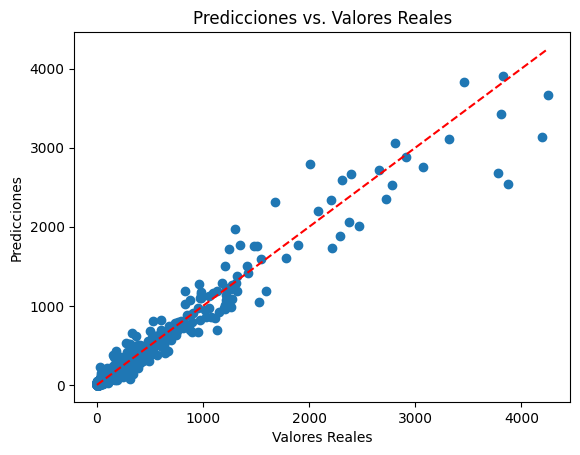

R^2: 0.9544100672784994
MAE: 48.92914194017875
MSE: 12667.22575154148
RMSE: 112.54877054655675
 
Intercept: -8.72897312885533
Coefficients:


,Feature,Coefficient
0,new_deceased_lag_1,0.262918
1,new_deceased_lag_2,0.000000
2,new_deceased_lag_3,0.000000
3,new_deceased_lag_4,0.000000
4,new_deceased_lag_5,0.000000
5,new_deceased_lag_6,0.114670
6,new_deceased_lag_7,0.612224
7,new_deceased_lag_8,0.000000
8,country_code_BR,4.289677
9,country_code_CL,0.000000


In [3]:
# Visualizar predicciones vs. valores reales
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

# Calcular métricas de evaluación
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Crear un DataFrame con los nombres de las características y sus coeficientes
coef_df = pd.DataFrame({'Feature': feature_cols, 'Coefficient': model.coef_})

# Mostrar las métricas de error
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(" ")

# Mostrar los coeficientes del modelo
print("Intercept:", model.intercept_)
print("Coefficients:")
coef_df

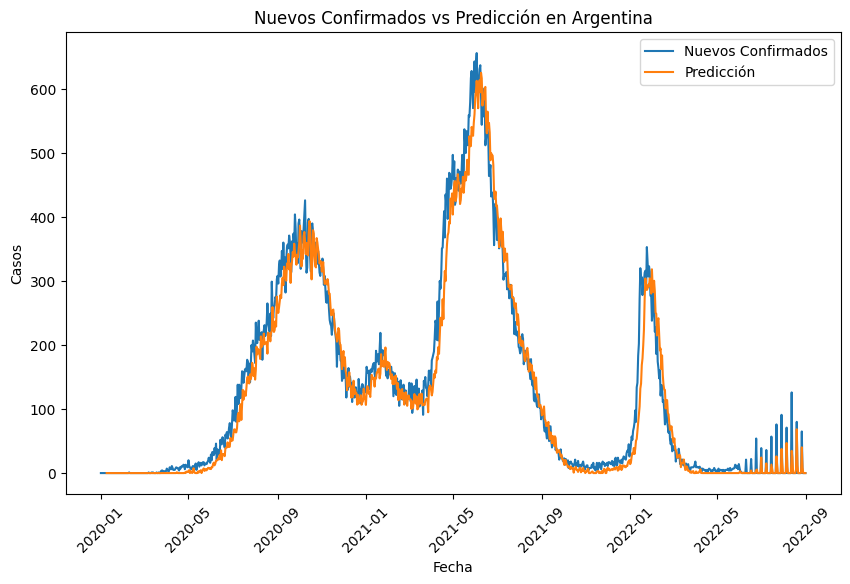

In [4]:
import matplotlib.pyplot as plt

# Filtrar el DataFrame para el país 'AR'
df_ar = df[df['country_code'] == 'AR']

# Crear la figura y el eje
plt.figure(figsize=(10, 6))
plt.plot(df_ar['date'], df_ar['new_deceased'], label='Nuevos Confirmados')
plt.plot(df_ar['date'], df_ar['Prediccion'], label='Predicción')

# Añadir títulos y etiquetas
plt.title('Nuevos Confirmados vs Predicción en Argentina')
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.legend()

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()


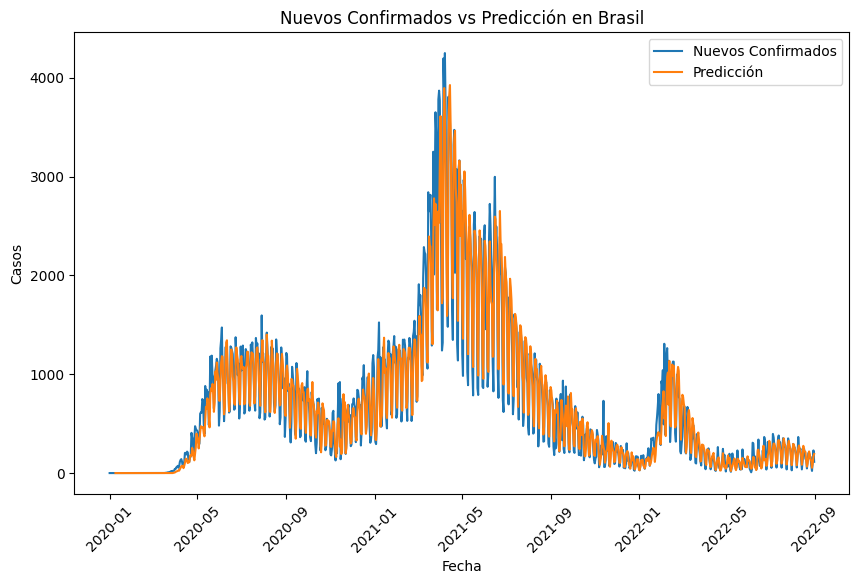

In [5]:
import matplotlib.pyplot as plt

# Filtrar el DataFrame para el país 'BR'
df_ar = df[df['country_code'] == 'BR']

# Crear la figura y el eje
plt.figure(figsize=(10, 6))
plt.plot(df_ar['date'], df_ar['new_deceased'], label='Nuevos Confirmados')
plt.plot(df_ar['date'], df_ar['Prediccion'], label='Predicción')

# Añadir títulos y etiquetas
plt.title('Nuevos Confirmados vs Predicción en Brasil')
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.legend()

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

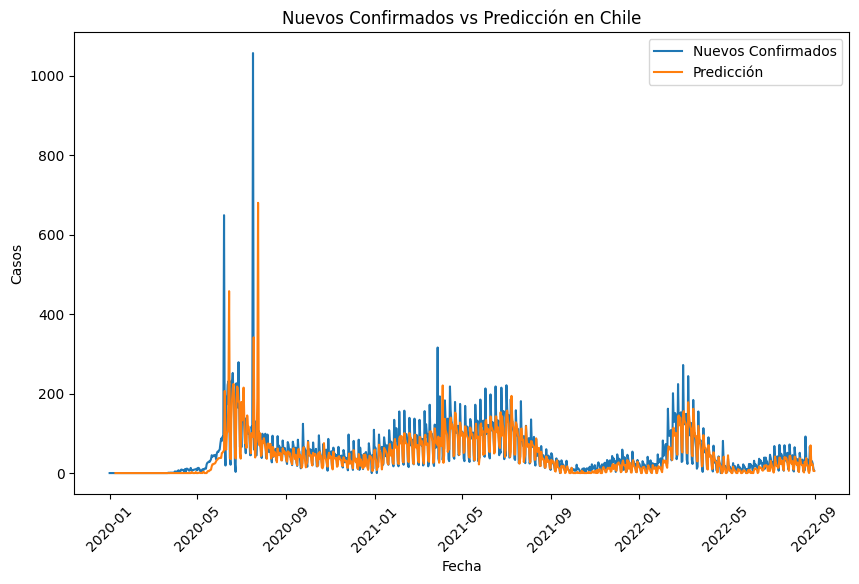

In [6]:
import matplotlib.pyplot as plt

# Filtrar el DataFrame para el país 'CL'
df_ar = df[df['country_code'] == 'CL']

# Crear la figura y el eje
plt.figure(figsize=(10, 6))
plt.plot(df_ar['date'], df_ar['new_deceased'], label='Nuevos Confirmados')
plt.plot(df_ar['date'], df_ar['Prediccion'], label='Predicción')

# Añadir títulos y etiquetas
plt.title('Nuevos Confirmados vs Predicción en Chile')
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.legend()

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

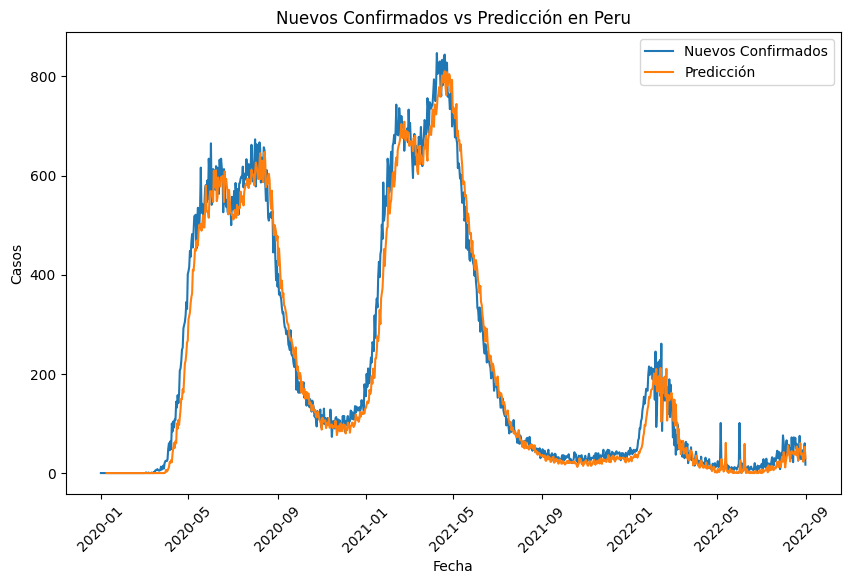

In [7]:
import matplotlib.pyplot as plt

# Filtrar el DataFrame para el país 'PE'
df_ar = df[df['country_code'] == 'PE']

# Crear la figura y el eje
plt.figure(figsize=(10, 6))
plt.plot(df_ar['date'], df_ar['new_deceased'], label='Nuevos Confirmados')
plt.plot(df_ar['date'], df_ar['Prediccion'], label='Predicción')

# Añadir títulos y etiquetas
plt.title('Nuevos Confirmados vs Predicción en Peru')
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.legend()

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

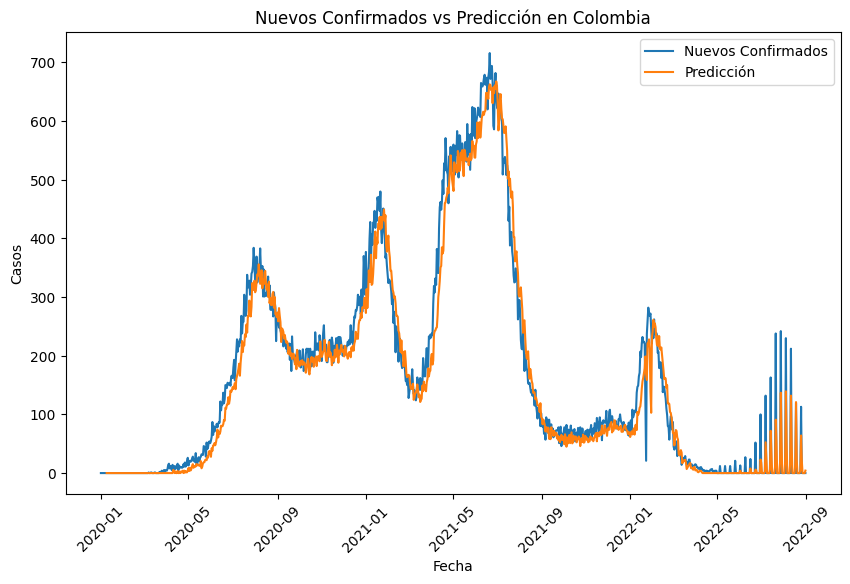

In [8]:
import matplotlib.pyplot as plt

# Filtrar el DataFrame para el país 'CO'
df_ar = df[df['country_code'] == 'CO']

# Crear la figura y el eje
plt.figure(figsize=(10, 6))
plt.plot(df_ar['date'], df_ar['new_deceased'], label='Nuevos Confirmados')
plt.plot(df_ar['date'], df_ar['Prediccion'], label='Predicción')

# Añadir títulos y etiquetas
plt.title('Nuevos Confirmados vs Predicción en Colombia')
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.legend()

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

In [9]:
df=df[['location_key', 'date', 'new_deceased', 'day_of_week', 'Prediccion']]

In [10]:
df.to_csv('../../data/processed/prediccion_ML_deceased.csv', index=False)